Importing all the libraries

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
import scipy.sparse as sparse

Reading the data

In [2]:
credits = pd.read_csv("./Desktop/theMoviesDataset/credits.csv")
keywords = pd.read_csv("./Desktop/theMoviesDataset/keywords.csv")
md = pd.read_csv("./Desktop/theMoviesDataset/movies_metadata.csv", low_memory=False)
md.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [3]:
md = md.loc[md.groupby('title')['vote_count'].idxmax()]
md.reset_index(drop=True, inplace=True)
md.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,NaN,0,"[{'id': 99, 'name': 'Documentary'}]",http://www.womenartrevolution.com/,55245,tt1699720,en,!Women Art Revolution,"Through intimate interviews, provocative art, ...",...,2010-01-01,0.0,83.0,[],Released,40 years in the making!,!Women Art Revolution,False,4.3,2.0
1,False,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,41371,tt1637976,en,#1 Cheerleader Camp,A pair of horny college guys get summer jobs a...,...,2010-07-27,0.0,95.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Grab your spirit sticks!,#1 Cheerleader Camp,False,3.4,23.0
2,False,NaN,1500000,"[{'id': 18, 'name': 'Drama'}, {'id': 9648, 'na...",http://www.hashtaghorror.com/,301325,tt3526286,de,#Horror,"Inspired by actual events, a group of 12 year ...",...,2015-11-20,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Death is trending.,#Horror,False,3.4,53.0
3,False,NaN,0,"[{'id': 99, 'name': 'Documentary'}]",http://www.chicagogirlfilm.com/,267752,tt3060338,en,#chicagoGirl,From her childhood bedroom in the Chicago subu...,...,2013-11-21,0.0,74.0,[],Released,The Social Network Takes on a Dictator,#chicagoGirl,False,7.0,1.0
4,False,NaN,0,"[{'id': 37, 'name': 'Western'}]",NaN,143747,tt0060697,it,Mille dollari sul nero,Johnny Liston has just been released from pris...,...,1966-12-18,0.0,104.0,"[{'iso_639_1': 'it', 'name': 'Italiano'}, {'is...",Released,NaN,"$1,000 on the Black",False,6.0,2.0


Checking which features are more relevant since the dataset is very large

In [4]:
md["adult"].value_counts()

adult
False    42269
True         8
Name: count, dtype: int64

In [5]:
md["status"].value_counts()

status
Released           41872
Rumored              201
Post Production       92
In Production         20
Planned               14
Canceled               2
Name: count, dtype: int64

In [6]:
md["video"].value_counts()

video
False    42186
True        91
Name: count, dtype: int64

Checking the distribution of Vote count to find that many movies have very less vote count.

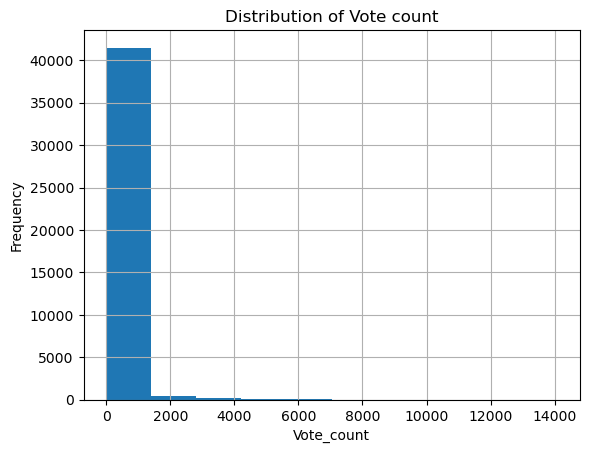

count    42277.000000
mean       115.962391
std        507.614096
min          0.000000
25%          3.000000
50%         10.000000
75%         36.000000
max      14075.000000
Name: vote_count, dtype: float64
percentile_90 = 174.0


In [7]:
md['vote_count'].hist()
plt.xlabel('Vote_count')
plt.ylabel('Frequency')
plt.title('Distribution of Vote count')
plt.show()
print(md['vote_count'].describe())
percentile_90 = md['vote_count'].quantile(0.9)
print('percentile_90 = ' + str(percentile_90))

We want some vote metric that accurately represents the votes even if vote count is less

In [8]:
mean_vote_average = md['vote_average'].mean() 
min_votes_required = md['vote_count'].quantile(0.20)  
def calculate_weighted_rating(row, min_votes=min_votes_required, avg_vote=mean_vote_average):
    votes = row['vote_count']
    rating = row['vote_average']
    return (votes / (votes + min_votes) * rating) + (min_votes / (min_votes + votes) * avg_vote)
md['weighted_rating'] = md.apply(calculate_weighted_rating, axis=1)


In [9]:
md.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,weighted_rating
0,False,NaN,0,"[{'id': 99, 'name': 'Documentary'}]",http://www.womenartrevolution.com/,55245,tt1699720,en,!Women Art Revolution,"Through intimate interviews, provocative art, ...",...,0.0,83.0,[],Released,40 years in the making!,!Women Art Revolution,False,4.3,2.0,4.966589
1,False,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,41371,tt1637976,en,#1 Cheerleader Camp,A pair of horny college guys get summer jobs a...,...,0.0,95.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Grab your spirit sticks!,#1 Cheerleader Camp,False,3.4,23.0,3.578654
2,False,NaN,1500000,"[{'id': 18, 'name': 'Drama'}, {'id': 9648, 'na...",http://www.hashtaghorror.com/,301325,tt3526286,de,#Horror,"Inspired by actual events, a group of 12 year ...",...,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Death is trending.,#Horror,False,3.4,53.0,3.481207
3,False,NaN,0,"[{'id': 99, 'name': 'Documentary'}]",http://www.chicagogirlfilm.com/,267752,tt3060338,en,#chicagoGirl,From her childhood bedroom in the Chicago subu...,...,0.0,74.0,[],Released,The Social Network Takes on a Dictator,#chicagoGirl,False,7.0,1.0,6.088786
4,False,NaN,0,"[{'id': 37, 'name': 'Western'}]",NaN,143747,tt0060697,it,Mille dollari sul nero,Johnny Liston has just been released from pris...,...,0.0,104.0,"[{'iso_639_1': 'it', 'name': 'Italiano'}, {'is...",Released,NaN,"$1,000 on the Black",False,6.0,2.0,5.816589


Since most used language in the dataset is english we substitute all other languages to non english or nen

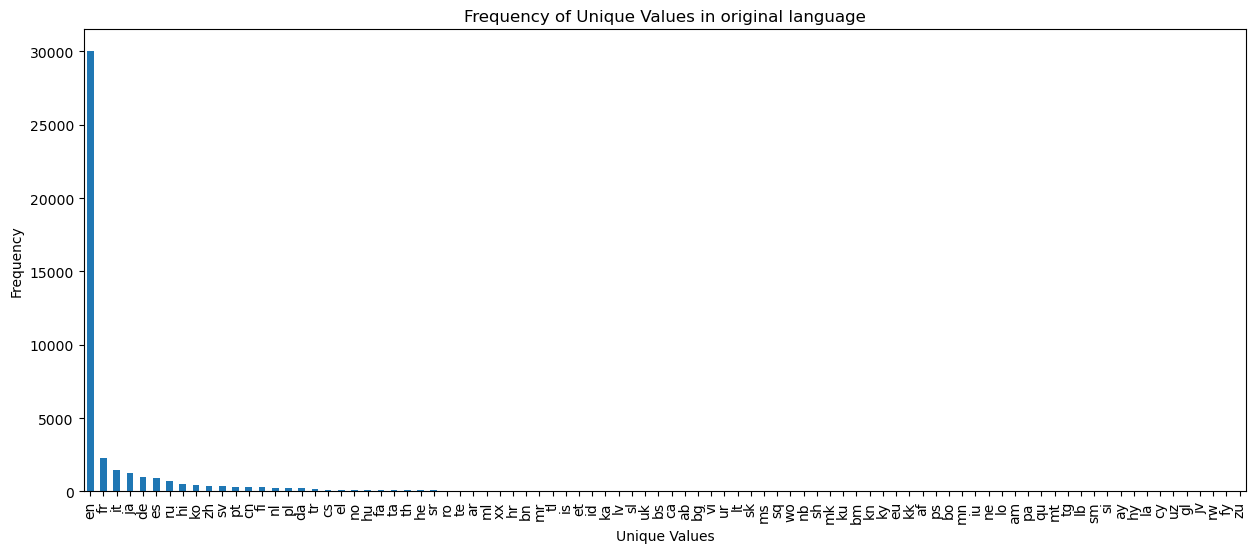

In [10]:
value_counts = md["original_language"].value_counts()
plt.figure(figsize=(15, 6))
value_counts.plot(kind='bar')
plt.title(f'Frequency of Unique Values in original language')
plt.xlabel('Unique Values')
plt.ylabel('Frequency')
plt.show()


In [11]:
md['original_language'] = md['original_language'].apply(lambda x: x if x == 'en' else 'nen')

In [12]:
md['popularity'] = pd.to_numeric(md['popularity'], errors='coerce')
md['popularity'].info()
md['popularity'].fillna(md['popularity'].mean(), inplace=True)
md['budget'] = pd.to_numeric(md['budget'], errors='coerce')
md['budget'].info()
md['budget'].fillna(md['budget'].mean(), inplace=True)

<class 'pandas.core.series.Series'>
RangeIndex: 42277 entries, 0 to 42276
Series name: popularity
Non-Null Count  Dtype  
--------------  -----  
42277 non-null  float64
dtypes: float64(1)
memory usage: 330.4 KB
<class 'pandas.core.series.Series'>
RangeIndex: 42277 entries, 0 to 42276
Series name: budget
Non-Null Count  Dtype
--------------  -----
42277 non-null  int64
dtypes: int64(1)
memory usage: 330.4 KB


This correlation matrix represents relation that not all popular movies have a good weighted rating

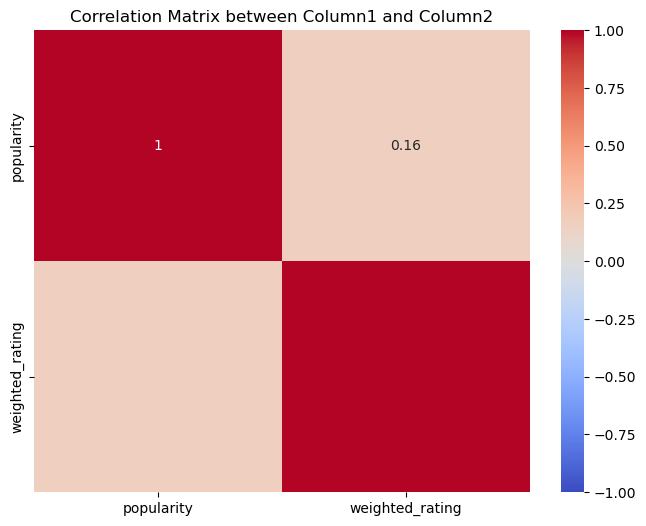

In [13]:
corr_matrix = md[['popularity', 'weighted_rating']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix between Column1 and Column2')
plt.show()

Converting the dictionaries to list dropping the ids

In [14]:
md['genres'] = md['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
md['year'] = pd.to_datetime(md['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [15]:
md.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,weighted_rating,year
0,False,NaN,0,[Documentary],http://www.womenartrevolution.com/,55245,tt1699720,en,!Women Art Revolution,"Through intimate interviews, provocative art, ...",...,83.0,[],Released,40 years in the making!,!Women Art Revolution,False,4.3,2.0,4.966589,2010
1,False,NaN,0,"[Comedy, Drama]",NaN,41371,tt1637976,en,#1 Cheerleader Camp,A pair of horny college guys get summer jobs a...,...,95.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Grab your spirit sticks!,#1 Cheerleader Camp,False,3.4,23.0,3.578654,2010
2,False,NaN,1500000,"[Drama, Mystery, Horror, Thriller]",http://www.hashtaghorror.com/,301325,tt3526286,nen,#Horror,"Inspired by actual events, a group of 12 year ...",...,90.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Death is trending.,#Horror,False,3.4,53.0,3.481207,2015
3,False,NaN,0,[Documentary],http://www.chicagogirlfilm.com/,267752,tt3060338,en,#chicagoGirl,From her childhood bedroom in the Chicago subu...,...,74.0,[],Released,The Social Network Takes on a Dictator,#chicagoGirl,False,7.0,1.0,6.088786,2013
4,False,NaN,0,[Western],NaN,143747,tt0060697,nen,Mille dollari sul nero,Johnny Liston has just been released from pris...,...,104.0,"[{'iso_639_1': 'it', 'name': 'Italiano'}, {'is...",Released,NaN,"$1,000 on the Black",False,6.0,2.0,5.816589,1966


Rearranging data in proper format to apply cosine similarity

In [16]:
links = pd.read_csv("./Desktop/theMoviesDataset/links.csv")
links = links[links['tmdbId'].notnull()]['tmdbId'].astype('int')
print (md[pd.to_numeric(md['id'], errors='coerce').isnull()])
#These have weird values filled in some places hence converting them to int

Empty DataFrame
Columns: [adult, belongs_to_collection, budget, genres, homepage, id, imdb_id, original_language, original_title, overview, popularity, poster_path, production_companies, production_countries, release_date, revenue, runtime, spoken_languages, status, tagline, title, video, vote_average, vote_count, weighted_rating, year]
Index: []

[0 rows x 26 columns]


In [17]:
md = md.drop([19730, 29503, 35587])
md['id'] = md['id'].astype('int')

In [18]:
#using cosine similarity to get the most relevant movies
def get_recommendations(title, cosine_sim):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:8]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [19]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
md = md.merge(credits, on='id')
md = md.merge(keywords, on='id')
smd1 = md[md['id'].isin(links)]

features = ['cast', 'crew', 'keywords']
for feature in features:
    smd1[feature] = smd1[feature].apply(literal_eval)

In [20]:
#code to extract director from crew
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan
smd1['director'] = smd1['crew'].apply(get_director)
smd1.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,title,video,vote_average,vote_count,weighted_rating,year,cast,crew,keywords,director
0,False,NaN,0,[Documentary],http://www.womenartrevolution.com/,55245,tt1699720,en,!Women Art Revolution,"Through intimate interviews, provocative art, ...",...,!Women Art Revolution,False,4.3,2.0,4.966589,2010,"[{'cast_id': 1001, 'character': 'Herself', 'cr...","[{'credit_id': '52fe48c3c3a36847f8178265', 'de...","[{'id': 2383, 'name': 'feminism'}, {'id': 1870...",Lynn Hershman Leeson
1,False,NaN,0,"[Comedy, Drama]",NaN,41371,tt1637976,en,#1 Cheerleader Camp,A pair of horny college guys get summer jobs a...,...,#1 Cheerleader Camp,False,3.4,23.0,3.578654,2010,"[{'cast_id': 1, 'character': 'Charlene Tilton'...","[{'credit_id': '52fe45c4c3a36847f80d96f3', 'de...","[{'id': 6075, 'name': 'sport'}]",Mark Quod
2,False,NaN,1500000,"[Drama, Mystery, Horror, Thriller]",http://www.hashtaghorror.com/,301325,tt3526286,nen,#Horror,"Inspired by actual events, a group of 12 year ...",...,#Horror,False,3.4,53.0,3.481207,2015,"[{'cast_id': 0, 'character': 'Alex's 12-Step F...","[{'credit_id': '545bbabf0e0a261fb9002212', 'de...",[],Tara Subkoff
3,False,NaN,1500000,"[Drama, Mystery, Horror, Thriller]",http://www.hashtaghorror.com/,301325,tt3526286,nen,#Horror,"Inspired by actual events, a group of 12 year ...",...,#Horror,False,3.4,53.0,3.481207,2015,"[{'cast_id': 0, 'character': 'Alex's 12-Step F...","[{'credit_id': '545bbabf0e0a261fb9002212', 'de...",[],Tara Subkoff
4,False,NaN,0,[Documentary],http://www.chicagogirlfilm.com/,267752,tt3060338,en,#chicagoGirl,From her childhood bedroom in the Chicago subu...,...,#chicagoGirl,False,7.0,1.0,6.088786,2013,[],"[{'credit_id': '5362c9a7c3a368156f00049f', 'de...",[],Joe Piscatella


In [21]:
print(smd1.columns)


Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'weighted_rating', 'year', 'cast', 'crew',
       'keywords', 'director'],
      dtype='object')


In [22]:
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #limiting the names to less than or equal to three
        return names[:3] if len(names) > 3 else names
    return []

smd1['cast'] = smd1['cast'].apply(get_list)
smd1['keywords'] = smd1['keywords'].apply(get_list)


smd1[['title', 'cast', 'director', 'keywords', 'genres']].head(3)

,title,cast,director,keywords,genres
0,!Women Art Revolution,[Lynn Hershman Leeson],Lynn Hershman Leeson,"[feminism, woman director]",[Documentary]
1,#1 Cheerleader Camp,"[Charlene Tilton, Jay Gillespie, Harmony Blossom]",Mark Quod,[sport],"[Comedy, Drama]"
2,#Horror,"[Taryn Manning, Natasha Lyonne, Chloë Sevigny]",Tara Subkoff,[],"[Drama, Mystery, Horror, Thriller]"


In [23]:
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #replacing empty places with ""
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    smd1[feature] = smd1[feature].apply(clean_data)
smd1['director'] = smd1['director'].apply(lambda x: [x,x, x])
smd1.head(3)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,title,video,vote_average,vote_count,weighted_rating,year,cast,crew,keywords,director
0,False,NaN,0,[documentary],http://www.womenartrevolution.com/,55245,tt1699720,en,!Women Art Revolution,"Through intimate interviews, provocative art, ...",...,!Women Art Revolution,False,4.3,2.0,4.966589,2010,[lynnhershmanleeson],"[{'credit_id': '52fe48c3c3a36847f8178265', 'de...","[feminism, womandirector]","[lynnhershmanleeson, lynnhershmanleeson, lynnh..."
1,False,NaN,0,"[comedy, drama]",NaN,41371,tt1637976,en,#1 Cheerleader Camp,A pair of horny college guys get summer jobs a...,...,#1 Cheerleader Camp,False,3.4,23.0,3.578654,2010,"[charlenetilton, jaygillespie, harmonyblossom]","[{'credit_id': '52fe45c4c3a36847f80d96f3', 'de...",[sport],"[markquod, markquod, markquod]"
2,False,NaN,1500000,"[drama, mystery, horror, thriller]",http://www.hashtaghorror.com/,301325,tt3526286,nen,#Horror,"Inspired by actual events, a group of 12 year ...",...,#Horror,False,3.4,53.0,3.481207,2015,"[tarynmanning, natashalyonne, chloësevigny]","[{'credit_id': '545bbabf0e0a261fb9002212', 'de...",[],"[tarasubkoff, tarasubkoff, tarasubkoff]"


Creating a group of all the keywords in the data joining them by the string to make a new column that has all the important features

In [24]:
def create_group(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast'])  + ' '.join(x['director']) + ' '.join(x['genres']) + ' ' + str(x['weighted_rating']) + ' ' + str(x['popularity']) + ' ' + str(x['budget'])
smd1['group'] = smd1.apply(create_group, axis=1)
smd1[['title', 'cast', 'director', 'keywords', 'genres', 'group']].head(3)

,title,cast,director,keywords,genres,group
0,!Women Art Revolution,[lynnhershmanleeson],"[lynnhershmanleeson, lynnhershmanleeson, lynnh...","[feminism, womandirector]",[documentary],feminism womandirector lynnhershmanleesonlynnh...
1,#1 Cheerleader Camp,"[charlenetilton, jaygillespie, harmonyblossom]","[markquod, markquod, markquod]",[sport],"[comedy, drama]",sport charlenetilton jaygillespie harmonybloss...
2,#Horror,"[tarynmanning, natashalyonne, chloësevigny]","[tarasubkoff, tarasubkoff, tarasubkoff]",[],"[drama, mystery, horror, thriller]",tarynmanning natashalyonne chloësevignytarasu...


In [25]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(smd1['group'])
cosine_sim = cosine_similarity(count_matrix, count_matrix)

smd1 = smd1.reset_index()
titles = smd1['title']
indices = pd.Series(smd1.index, i+ndex=smd1['title'])

indices.head()
print(indices)

title
!Women Art Revolution                                                       0
#1 Cheerleader Camp                                                         1
#Horror                                                                     2
#Horror                                                                     3
#chicagoGirl                                                                4
                                                                        ...  
هیچ کجا هیچ کس                                                          43240
‘Rameau’s Nephew’ by Diderot (Thanx to Dennis Young) by Wilma Schoen    43241
’Round Midnight                                                         43242
…And the Fifth Horseman Is Fear                                         43243
ファンタスティポ                                                                43244
Length: 43245, dtype: int64


In [31]:
get_recommendations('Iron Man 3',cosine_sim)

16406                      Iron Man 2
270                              2012
3492          Avengers: Age of Ultron
25201                   Power Rangers
26728    Rogue One: A Star Wars Story
17843             Kiss Kiss Bang Bang
272                     2012: Ice Age
Name: title, dtype: object